In [1254]:
# CMPS140 Project - How to Become Top Earner in Airbnb?
# Tangni Wang, Tung Hoi Man, Yunxiang Fu
# {twang63, tuman, yfu7}@ucsc.edu

In [1255]:
# Tried:
# dropna for new_score_reviews

# To do:
# Generate graph


In [1256]:
import warnings
warnings.simplefilter("ignore")

import sklearn # sci-kit learn
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [1257]:
# Helper functions
def correction(x):
    '''
    Columns value corrections
    '''
    if type(x)==str:
        x=x.replace('$','')
        x=x.replace(',','')
        x=float(x)    
    return (x)

def correction2(x):
    '''
    Columns value corrections
    '''
    if type(x)==str:
        x=x.replace('%','')
        x=float(x)/100.0
    return (x)

def to_int(x):
    '''
    Columns value corrections
    '''
    if x=='f':
        x=x.replace('f','0')
    elif x=='t':
        x=x.replace('t','1')
    else:
        x= '0'
    return int(x)

# def changeTime(x):
#     '''
#     change host_response_time columns from string into numerical.
#     '''
#     if x == 'within an hour':
#         x=x.replace('within an hour', '1')
#     elif x == 'within a few hours':
#         x=x.replace('within a few hours', '4')
#     elif x == 'within a day':
#         x=x.replace('within a day', '24')
#     elif x == 'a few days or more':
#         x=x.replace('a few days or more', '48')
#     else:
#         x='96'
        
#     return int(x)

def changeTime(x):
    '''
    change host_response_time columns from string into numerical.
    '''
    if x == 'within an hour':
        x='1'
    elif x == 'within a few hours':
        x='4'
    elif x == 'within a day':
        x='24'
    elif x == 'a few days or more':
        x='48'
    else:
        x='96'
        
    return x

def convertPolicy(x):
    '''
    Convert cancellation_policy columns from string into numerical.
    '''
    if x == 'strict':
        x=x.replace('strict', '1')
    elif x == 'moderate':
        x=x.replace('moderate', '3')
    elif x == 'flexible':
        x=x.replace('flexible', '5')
    else:
        x='3'
        
    return int(x)

In [1258]:
# Parsing csv file
seattle_file_path = 'seattle_data/listings.csv'
seattle_data = pd.read_csv(seattle_file_path)
# seattle_data.columns

In [1259]:
# Make a new attribute for prediction
seattle_data['new_score_reviews'] = seattle_data['reviews_per_month'] * seattle_data['review_scores_rating'] / 10
# seattle_data.describe()
# seattle_data

In [1260]:
# Define top performers and low performers
top90flag = seattle_data['new_score_reviews'].quantile(0.9)
upto25flag = seattle_data['new_score_reviews'].quantile(0.25)

seattle_data['top90'] = seattle_data.new_score_reviews >= top90flag
seattle_data['upto25'] = seattle_data.new_score_reviews <= upto25flag

print('The boundaries of top performer listings:', top90flag)
print('The boundaries of low performer listings:', upto25flag)

The boundaries of top performer listings: 44.109
The boundaries of low performer listings: 6.480000000000001


In [1261]:
# Data Processing

# Drop useless columns
useless_colmuns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
    'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
    'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
    'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
    'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'street', 
    'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'market',
    'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 
    'room_type', 'bed_type', 'amenities', 'square_feet', 'guests_included', 'maximum_nights', 'calendar_updated', 
    'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
    'calendar_last_scraped', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_accuracy', 
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
    'review_scores_value', 'requires_license', 'license', 'jurisdiction_names', 'require_guest_profile_picture', 
    'require_guest_phone_verification', 'calculated_host_listings_count', 'review_scores_rating', 'reviews_per_month'
]
seattle_data.drop(useless_colmuns, axis=1)

# Remove $: price, weekly_price, security_deposit, extra_people, cleaning_fee
seattle_data['price']=seattle_data['price'].map(lambda x: correction(x))
seattle_data['weekly_price'] = seattle_data['weekly_price'].map(lambda x: correction(x))
seattle_data['monthly_price'] = seattle_data['monthly_price'].map(lambda x: correction(x))
seattle_data['security_deposit'] = seattle_data['security_deposit'].map(lambda x: correction(x))
seattle_data['extra_people'] = seattle_data['extra_people'].map(lambda x: correction(x))
seattle_data['cleaning_fee'] = seattle_data['cleaning_fee'].map(lambda x: correction(x))

# Convert string to number: host_response_time, cancellation_policy
seattle_data['host_response_time'] = seattle_data['host_response_time'].apply(changeTime).astype(int)
seattle_data['cancellation_policy'] = seattle_data['cancellation_policy'].map(lambda x: convertPolicy(x))

# Convert boolean t/f to int 1/0: host_is_superhost, host_identity_verified, instant_bookable
for i in seattle_data.columns:
    
    if set(seattle_data[i])=={'t','f'}:
        seattle_data[i]=seattle_data[i].apply(to_int)
        
    elif set(seattle_data[i]) == {'t','f',np.nan}:
        seattle_data[i]=seattle_data[i].apply(to_int)

# Fill missing value with reasonable values like 0 or 1.
seattle_data['new_score_reviews'].fillna(0, inplace = True)
seattle_data['accommodates'].fillna(0, inplace = True)
seattle_data['bathrooms'].fillna(0, inplace = True)
seattle_data['beds'].fillna(0, inplace = True)
seattle_data['price'].fillna(0, inplace = True)
seattle_data['weekly_price'].fillna(0, inplace = True)
seattle_data['monthly_price'].fillna(0, inplace = True)
seattle_data['security_deposit'].fillna(0, inplace = True)
seattle_data['cleaning_fee'].fillna(0, inplace = True)
seattle_data['extra_people'].fillna(0, inplace = True)
seattle_data['minimum_nights'].fillna(1, inplace = True)

# Relevant Features
seattle_features = ['zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price', 
                    'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 
                    'host_response_time', 'host_is_superhost', 'host_identity_verified', 'instant_bookable', 
                    'cancellation_policy', 'new_score_reviews' 
                    ]

# Drop rows if any feature still has missing value
seattle_data = seattle_data[seattle_features].dropna()

# print(seattle_data[seattle_features])

In [1262]:
# Needed features:
# X is the independent variable
features = ['zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price', 
                    'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 
                    'host_response_time', 'host_is_superhost', 'host_identity_verified', 'instant_bookable', 
                    'cancellation_policy'
                    ]

X = seattle_data[features]

# Statistic of seattle features
# X
X.describe()

,zipcode,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,minimum_nights,host_response_time,host_is_superhost,host_identity_verified,instant_bookable,cancellation_policy
count,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000
mean,98115.701971,3.348226,1.254008,1.307490,1.735874,127.937714,414.700394,1039.261761,140.737451,45.100131,10.671222,2.372668,18.822339,0.204205,0.785020,0.154271,2.862286
std,16.492646,1.973377,0.594677,0.882151,1.140216,90.254370,551.699388,1678.752671,237.617382,49.953030,17.598870,16.333614,32.013543,0.403172,0.410863,0.361256,1.633624
min,98101.000000,1.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,98104.000000,2.000000,1.000000,1.000000,1.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,98112.000000,3.000000,1.000000,1.000000,1.000000,100.000000,262.000000,0.000000,0.000000,30.000000,0.000000,2.000000,4.000000,0.000000,1.000000,0.000000,3.000000
75%,98121.000000,4.000000,1.000000,2.000000,2.000000,150.000000,670.000000,1890.000000,200.000000,65.000000,20.000000,2.000000,24.000000,0.000000,1.000000,0.000000,5.000000
max,98199.000000,16.000000,8.000000,7.000000,15.000000,1000.000000,6300.000000,19500.000000,5000.000000,300.000000,300.000000,1000.000000,96.000000,1.000000,1.000000,1.000000,5.000000


In [1263]:
# Prediction target, dependent variable
y = seattle_data.new_score_reviews
# y
# y.describe()

In [1264]:
'''
The pairs plot builds on two basic figures, the histogram and the scatter plot. 
The histogram on the diagonal allows us to see the distribution of a single variable 
while the scatter plots on the upper and lower triangles show the relationship (or lack thereof) 
between two variables.
'''
# sns.pairplot(seattle_data)

'\nThe pairs plot builds on two basic figures, the histogram and the scatter plot. \nThe histogram on the diagonal allows us to see the distribution of a single variable \nwhile the scatter plots on the upper and lower triangles show the relationship (or lack thereof) \nbetween two variables.\n'

In [1265]:
'''
A histogram divides the variable into bins, counts the data points in each bin, 
and shows the bins on the x-axis and the counts on the y-axis.
'''
# sns.distplot(y)

'\nA histogram divides the variable into bins, counts the data points in each bin, \nand shows the bins on the x-axis and the counts on the y-axis.\n'

In [1266]:
# Correlation
'''
The correlation coefficient, or simply the correlation, is an index that ranges from -1 to 1. 
When the value is near zero, there is no linear relationship. 
As the correlation gets closer to plus or minus one, the relationship is stronger. 
A value of one (or negative one) indicates a perfect linear relationship between two variables.
'''
# result: 
# stronger correlation: host_is_superhost, instant_bookable, host_response_time, bedrooms, price, cleaning fee
# weaker corr: accommodates, beds, bathrooms, host_identity_verified
# almost no corr: zipcode, weekly_price, monthly_price, security_deposit, extra_people

# seattle_data.corr()

'\nThe correlation coefficient, or simply the correlation, is an index that ranges from -1 to 1. \nWhen the value is near zero, there is no linear relationship. \nAs the correlation gets closer to plus or minus one, the relationship is stronger. \nA value of one (or negative one) indicates a perfect linear relationship between two variables.\n'

In [1267]:
# Split training and testing set. Training = 80%. Testing = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3044, 17) (3044,)
(761, 17) (761,)


In [1268]:
# Baseline model
# Make prediction by mean or median
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

from sklearn.dummy import DummyRegressor
# from sklearn.metrics import r2_score

# Create a dummy regressor
baseline_model = DummyRegressor(strategy='mean')

# "Train" dummy regressor
baseline_model.fit(X_train, y_train)
# print(dummy_mean)

# Predict
# print("Baseline model predicitions using testing set ")
# print(X2.head())
# print("The predictions are:")
# print(baseline_model.predict(X_test))
print("The score is:")
print(baseline_model.score(X_test, y_test))
# r2_score(y_test, y_pred_bm)

The score is:
-3.2520698378668556e-06


[ 5.68293833 17.99799688 16.1062956  13.9314133  15.79165799 15.40204529
  4.99484888 26.89794495 14.67731319 25.56175191 27.77008597 18.78920016
 15.28502376 17.85187188 17.72174773 13.36997763 16.97748097  8.91998248
 10.31209256 12.98933631  8.29311388 17.09537373  6.12892963 14.36416321
 16.03889474 16.1728633   6.7613716  18.08158    12.66840117 24.32827571
 26.46180509 15.59529843 14.99237458 22.15013046 15.35680185  3.87809517
 23.68259926 25.56497674 27.69610299 16.19182934 14.48605495 24.1753683
 16.81948872 17.54630974  2.26801685 17.90080447 15.67999275 31.67860568
 12.31280229 25.35149332  6.65610975 28.69139962 17.50982624 27.57575523
 14.52080464 20.33900902 -1.92073969 12.66305651 34.20177277 12.83877787
 16.21527938 25.86128208 14.30378171 21.49452484 39.31592406 23.74887631
 35.15514458 10.94698129 16.80067666  3.77220898 36.19923845 15.47811879
 30.95252069 19.69745802 28.76056128 24.69309648  8.93709418 12.68023791
 23.35608664 17.23523198 12.44012619 19.43336566 15.

Text(0, 0.5, 'Predictions (y_pred_lm)')

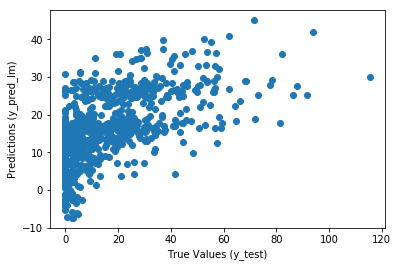

In [1269]:
# Linear Regression
lin_model = linear_model.LinearRegression()
lin_model = lin_model.fit(X_train, y_train)
y_pred_lm = lin_model.predict(X_test)
print(y_pred_lm)

plt.scatter(y_test, y_pred_lm)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_lm)")

In [1270]:
print("lin_model score:", lin_model.score(X_test, y_test))
# The mean absolute error (mae)
print("lin_model mae:", mean_absolute_error(y_pred_lm, y_test))

lin_model score: 0.3223501586770844
lin_model mae: 10.661385130886293


In [1271]:
# The coefficients
print('Coefficients: \n', lin_model.coef_)
# The mean squared error (mse)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction, same as score
print('Variance score (same as score): %.3f' % r2_score(y_test, y_pred))

Coefficients: 
 [-1.60501238e-02  9.59663259e-01  7.59530190e-02 -1.99980604e+00
 -1.03277111e-01 -1.20640722e-02  6.09900969e-04  2.14805937e-04
 -2.10722857e-03 -7.07223764e-02  4.66326070e-02 -1.61309119e-02
 -1.16148260e-01  1.04866759e+01  2.36693767e+00  9.50549861e+00
 -7.49124008e-01]
Mean squared error: 213.63
Variance score (same as score): 0.322


ridgecv_model score: 0.322341781688378
ridgecv_model mae: 10.661456777610573


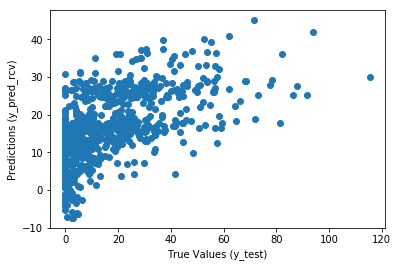

In [1272]:
# Ridge Regression with built-in cross-validation of the alpha parameter.
ridgecv_model = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], cv=6, fit_intercept=True, scoring=None,
    normalize=False)
ridgecv_model.fit(X_train, y_train)
# ridgecv_model.alpha_
y_pred_rcv = ridgecv_model.predict(X_test)
# print(y_pred_rcv)

plt.scatter(y_test, y_pred_rcv)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_rcv)")
print("ridgecv_model score:", ridgecv_model.score(X_test, y_test))
print("ridgecv_model mae:", mean_absolute_error(y_pred_rcv, y_test))

Text(0, 0.5, 'Predictions (y_pred_ridge)')

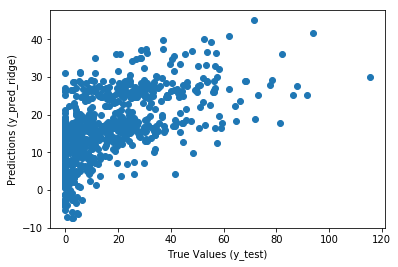

In [1273]:
# Ridge Regression
ridge_model = linear_model.Ridge(alpha=.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
ridge_model.fit(X_train, y_train)
# reg.coef_
# reg.intercept_
y_pred_ridge = ridge_model.predict(X_test)
# print(y_pred_ridge)

plt.scatter(y_test, y_pred_ridge)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_ridge)")

In [1274]:
print("ridge_model score:", ridge_model.score(X_test, y_test))
print("ridge_model mae:", mean_absolute_error(y_pred_ridge, y_test))

ridge_model score: 0.32230821067246496
ridge_model mae: 10.661743095356572


In [1275]:
# Perform 9-fold cross validation (cv)

scores = cross_val_score(lin_model, X, y, cv=9)
print("Cross-validated scores:", scores)                                         

# As you can see, the last fold improved the score of the original model — from 0.322 to 0.392

# Make cross validated predictions
y_pred_cvp = cross_val_predict(lin_model, X_test, y_test, cv=9)
# print(y_pred_cvp)
plt.scatter(y_test, y_pred_cvp)

# Cross-Predicted Accuracy, r2_score
accuracy = metrics.r2_score(y_test, y_pred_cvp)
print("Cross-Predicted Accuracy:", accuracy)

print("cross_val_predict mae:", mean_absolute_error(y_pred_cvp, y_test))

Text(0, 0.5, 'Predictions (y_pred_lasso)')

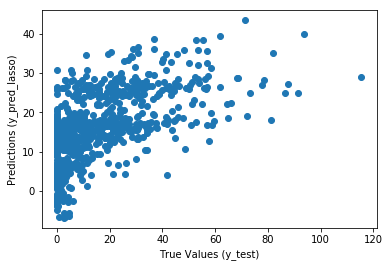

In [1276]:
# Lasso Regression
lasso_model = linear_model.Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

plt.scatter(y_test, y_pred_lasso)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_lasso)")

In [1277]:
print("lasso_model score:", lasso_model.score(X_test, y_test))
print("lasso_model mae:", mean_absolute_error(y_pred_lasso, y_test))

lasso_model score: 0.31782773995165603
lasso_model mae: 10.6980250128968


Text(0, 0.5, 'Predictions (y_pred_dtr)')

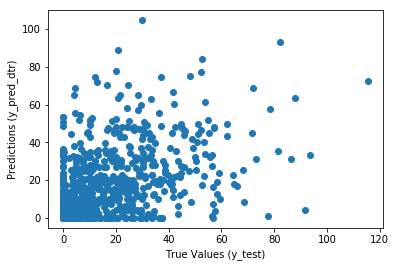

In [1278]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

dtr_model = DecisionTreeRegressor()
dtr_model = dtr_model.fit(X_train, y_train)
y_pred_dtr = dtr_model.predict(X_test)

plt.scatter(y_test, y_pred_dtr)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_dtr)")


In [1279]:
print("dtr_model score:", dtr_model.score(X_test, y_test))
print("dtr_model mae:", mean_absolute_error(y_pred_dtr, y_test))

dtr_model score: -0.12449911646759704
dtr_model mae: 13.091667104686815


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Text(0, 0.5, 'Predictions (y_pred_rfr)')

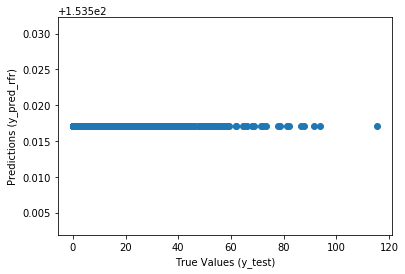

In [1280]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

X, y = make_regression(n_features=17, n_informative=2, random_state=0, shuffle=False)
rfr_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
rfr_model.fit(X, y)

print(rfr_model.feature_importances_)
y_pred_rfr = rfr_model.predict(X_test)
# print(y_pred_rfr)

plt.scatter(y_test, y_pred_rfr)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_rfr)")

In [1281]:
print("rfr_model score:", rfr_model.score(X_test, y_test))
print("rfr_model mae:", mean_absolute_error(y_pred_rfr, y_test))

rfr_model score: -59.538514337434734
rfr_model mae: 137.00080027704004
